## Enrichment of trans-eQTLs in the DHS regions

We look at the predicted trans-eQTLs and find the number of SNPs which are in the DHS regions. Had we selected SNPs randomly, how many would have been in the DHS regions?

Enrichment = $\frac{\text{Fraction of trans-eQTLs in DHS region}}{\text{fraction of randomly selected SNPs in DHS region}}$

In [66]:
import sys
sys.path.append('../')
import numpy as np
import collections
import os
import sys
import json
import os 
from utils import utils
tissue_file = "../plots/tissues.txt"

resdir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_brainK15_freeze/summary"# pc_freeze/summary"
file_pcutoff = "0.0001"
trans_eqtls_file = "trans_eqtls_{:s}.txt".format(file_pcutoff)
snpsfile = "snps_list.txt"
chrmlist = np.arange(1,23)

pcutoff = 5e-8
mafcutoff = 0.01

In [42]:
title    = "multi_tissue"
dhs_file = "/cbscratch/franco/datasets/multi-tissue.master.ntypes.simple.hg19_hglift_hg38_clean.bed"

# title    = "DHSindex"
# dhs_file = "/cbscratch/franco/datasets/DHSindex/DHSindex.bed"
json_file = "../gtex_v8_metadata.json"

In [43]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

log10cutoff = -np.log10(pcutoff)

In [67]:
import operator

tshorts, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

sorted_tissues = [x[0] for x in sorted(tissue_samples.items(), key=operator.itemgetter(1))]

In [45]:
import mpmath
from operator import attrgetter

mpmath.mp.dps = 50
def pvalue(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
    
def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            chrom = int(arr[6])
            maf   = float(arr[7])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pvalue( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res

def read_snplist(filename, mafcutoff):
    rsidlist = list()
    maflist  = list()
    with open(filename) as instream:
        next(instream)
        for line in instream:
            arr  = line.strip().split("\t")
            rsid = arr[0]
            maf  = float(arr[1])
            if maf >= mafcutoff and maf <= (1 - mafcutoff) :
                rsidlist.append(rsid)
                maflist.append(maf)
    return rsidlist, maflist


In [46]:
def find_annotated(res_dict, dhs_file):
    dhs = open(dhs_file)
    line = dhs.readline()
    prev_chrm = 0
    nannot = 0

    while line:
        arr = line.rstrip().split()
        if arr[0][3:] == "X" or arr[0][3:] == "Y":
            line = dhs.readline()
            continue
        chrm = int(arr[0][3:])
        start = int(arr[1])
        end = int(arr[2])
        if chrm != prev_chrm:
            remaining = res_dict[chrm]
            checked = 0
        if len(remaining) == 0:
            ## No more SNPs in this chromosome, just continue reading the DHS file
            line = dhs.readline()
        else:
            for pos in remaining:
                if pos < start:
                    checked += 1
                    remaining = res_dict[chrm][checked:]
                    continue # go to next SNP
                elif pos > end:
                    line = dhs.readline()
                    break # go to next DHS line, keep checking the remaining results
                else:
                    # this is an annotated SNP
                    checked += 1
                    remaining = res_dict[chrm][checked:]
                    nannot += 1
                    continue # go to next SNP
        prev_chrm = chrm
    dhs.close()
    return nannot

#### Read any one tissue to get the list of rsids

In [53]:
filefmt = f'{resdir}/{tshorts[0]}/tejaas/{trans_eqtls_file}'
snpsfilefmt = f'{resdir}/{tshorts[0]}/tejaas/{snpsfile}'
trans_eqtls = tejaas(filefmt)
snps_list, maf_list = read_snplist(snpsfilefmt, mafcutoff)
print(f"Read {len(trans_eqtls)} trans-eQTLs")
print(f"Read {len(snps_list)} SNPs")
# Read 4210284 SNPs

trans_eqtls_signif = [x for x in trans_eqtls if x.logp >= log10cutoff and x.maf >= mafcutoff ]
print(f"{len(trans_eqtls_signif)} remain after filtering at {pcutoff} p-val and MAF {mafcutoff}")

Read 8008 trans-eQTLs
Read 3857505 SNPs
69 remain after filtering at 5e-08 p-val and MAF 0.01


#### Randomly select 1000 SNPs and see how many are annotated.

Repeat 20 times

In [47]:
def random_annotated(Nrand, snppos, chrmlist):
    mindist_rand = list()
    ratios = np.random.rand(len(chrmlist))
    ndraws = [int(x) for x in np.around(Nrand * ratios / np.sum(ratios))]
    for i, chrm in enumerate(chrmlist):
        N = ndraws[i]
        firstpos = snppos[chrm][0]
        lastpos  = snppos[chrm][1]
        rands = firstpos + np.random.rand(N) * (lastpos - firstpos)
        selects = np.sort([int(x) for x in rands])
        tfchrmlist = [x for x in tflist if x.chrom == chrm]
        tfstarts = [x.start for x in tflist if x.chrom == chrm]
        tfends = [x.end for x in tflist if x.chrom == chrm]
        for spos in selects:
            xmin = find_minimum_distance(spos, tfstarts, tfends)
            mindist_rand.append(xmin / 1e6)
    mindist_rand = np.array(mindist_rand)
    return mindist_rand

In [48]:
from statsmodels.distributions.empirical_distribution import ECDF

def annotated_random(gwrsids, nchoose, dhs_file):
    chooseidx = np.sort(np.random.choice(len(gwrsids), nchoose, replace = False))
    res_dict = dict()
    for chrm in range(1, 23):
        res_dict[chrm] = list()
    for idx in chooseidx:
        var_id = gwrsids[idx]
        info = var_id.split('_')
        chrm = int(info[0][3:])
        bppos = int(info[1])
        res_dict[chrm].append(bppos)
    nannot = find_annotated(res_dict, dhs_file)
    return nannot

def sample_binomial(n, p, NTIMES):
    array_n = list()
    for i in range(NTIMES):
        n_success = np.random.binomial(n, p)
        array_n.append(n_success)
    return array_n

def enrichment_pval(ntrans, DHS_RANDOM_BG, enrichment):
    randtrans = sample_binomial(ntrans, DHS_RANDOM_BG, 10000000)
    num_null = np.array(randtrans) /  ntrans

    null_enrichments = num_null / DHS_RANDOM_BG
    ecdf = ECDF(null_enrichments)
    pval = 1 - ecdf(enrichment)
    return pval

In [54]:
nchoose = 20000 # len(trans_eqtls_signif) 
niter = 20
nannot_rand = list()
for k in range(niter):
    nannot_k = annotated_random(snps_list, nchoose, dhs_file)
    print(f'Iteration {k}: {nannot_k}')
    nannot_rand.append(nannot_k)
    
dhs_frac_rand = np.mean(nannot_rand) / nchoose
print (f'Fraction of annotated SNPs: {dhs_frac_rand:7.4f}')

Iteration 0: 4036
Iteration 1: 4017
Iteration 2: 3950
Iteration 3: 4001
Iteration 4: 3961
Iteration 5: 3908
Iteration 6: 3952
Iteration 7: 4014
Iteration 8: 3997
Iteration 9: 3985
Iteration 10: 4002
Iteration 11: 3871
Iteration 12: 4074
Iteration 13: 4039
Iteration 14: 4052
Iteration 15: 3890
Iteration 16: 4014
Iteration 17: 3997
Iteration 18: 3994
Iteration 19: 3972
Fraction of annotated SNPs:  0.1993


In [55]:
res_dict = dict()
for chrm in range(1, 23):
    res_dict[chrm] = list()
for x in trans_eqtls_signif:
    res_dict[x.chrom].append(x.pos)
dhs_annotated = find_annotated(res_dict, dhs_file)
enrichment = float(dhs_annotated) / len(trans_eqtls_signif) / dhs_frac_rand
print(f"Annotated: {dhs_annotated}")
print(f"Enrichment: {enrichment}")

Annotated: 16
Enrichment: 1.163404951815039


#### Trans-eQTLs discovered by TEJAAS

In [56]:
transeqtls = dict()

for tissue in tshorts:  
    filefmt = f'{resdir}/{tissue}/tejaas/{trans_eqtls_file}'
    trans_eqtls = tejaas(filefmt)
    trans_eqtls_signif = [x for x in trans_eqtls if x.logp > log10cutoff]    
    transeqtls[tissue] = trans_eqtls_signif
    print(f'{tissue}: {len(transeqtls[tissue])} trans-eQTLs')

bam: 69 trans-eQTLs
ban: 7 trans-eQTLs
bca: 0 trans-eQTLs
bceh: 0 trans-eQTLs
bce: 0 trans-eQTLs
bco: 0 trans-eQTLs
bfr: 0 trans-eQTLs
bhi: 8 trans-eQTLs
bhy: 5 trans-eQTLs
bnu: 1 trans-eQTLs
bpu: 0 trans-eQTLs
bsp: 15 trans-eQTLs
bsu: 0 trans-eQTLs


In [57]:
dhs_annotated = dict()
enrichment = dict()
e_pval = dict()
min_trans_eqtl = 0

for tissue in tshorts:
    dhs_annotated[tissue] = 0
    if len(transeqtls[tissue]) > min_trans_eqtl:
        res_dict = dict()
        for chrm in range(1, 23):
            res_dict[chrm] = list()
        for x in  transeqtls[tissue]:
            res_dict[x.chrom].append(x.pos)
        dhs_annotated[tissue] = find_annotated(res_dict, dhs_file)
        enrichment[tissue] = float(dhs_annotated[tissue]) / len(transeqtls[tissue]) / dhs_frac_rand
        e_pval[tissue] = enrichment_pval(len(transeqtls[tissue]), dhs_frac_rand, enrichment[tissue])
        print (f'{tissue}: {dhs_annotated[tissue]} annotated out of {len(transeqtls[tissue])}. Enrichment = {enrichment[tissue]} - {e_pval[tissue]}')

bam: 16 annotated out of 69. Enrichment = 1.163404951815039 - 0.20101409999999997
ban: 1 annotated out of 7. Enrichment = 0.716740550671765 - 0.42142270000000004
bhi: 3 annotated out of 8. Enrichment = 1.8814439455133831 - 0.0555814
bhy: 1 annotated out of 5. Enrichment = 1.003436770940471 - 0.26136879999999996
bnu: 0 annotated out of 1. Enrichment = 0.0 - 0.19944669999999998
bsp: 3 annotated out of 15. Enrichment = 1.003436770940471 - 0.3494009


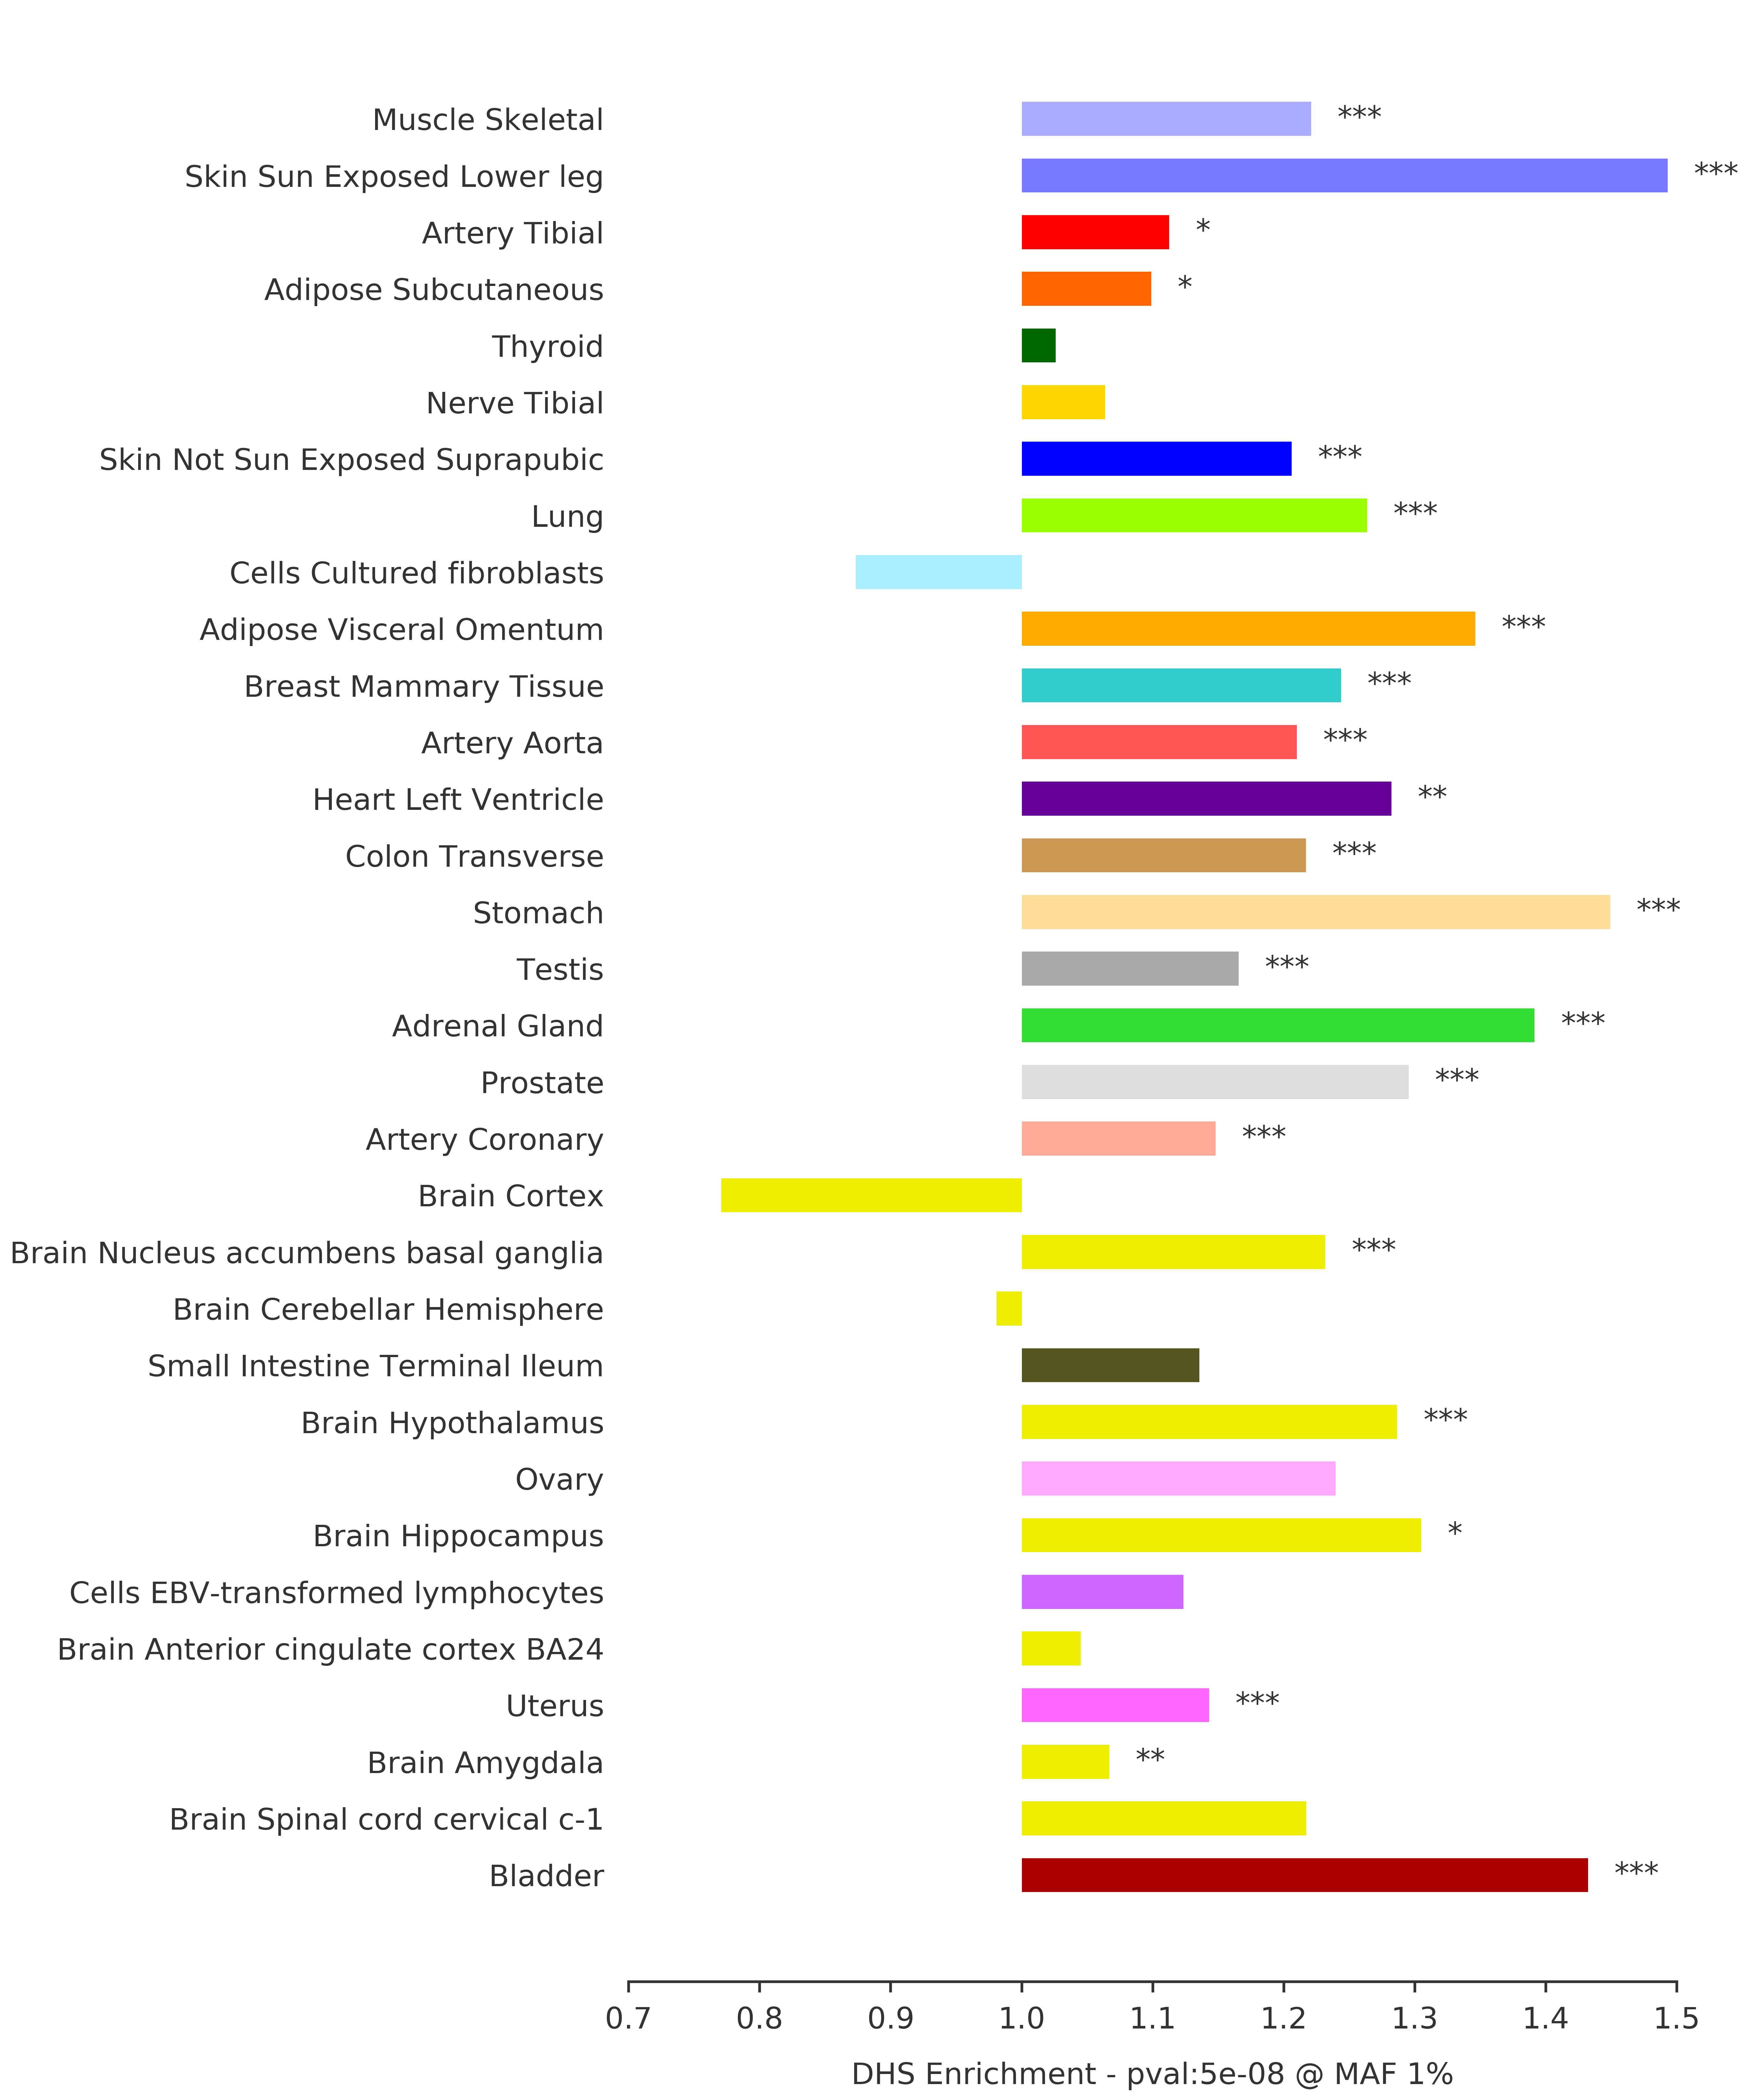

In [152]:
pcutoffs = [5e-9, 1e-8, 5e-8, 1e-7, 1e-6]
pcutoff = pcutoffs[2]
objects = list()
performance = list()
significance = list()
bar_colors = list()

maf = 0.01
title = "multi_tissue"
# title = "DHSindex"

if not os.path.exists(os.path.join(resdir, "maf{:.2f}".format(mafcutoff))):
    os.makedirs(os.path.join(resdir, "maf{:.2f}".format(mafcutoff)))
    
transeqtls    = dict()
dhs_annotated = dict()
enrichment    = dict()
e_pval        = dict()
infile = os.path.join("/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_pc_freeze/summary/maf{:.2f}/dhs_enrichment_{:s}_{:g}.txt".format(maf, title, pcutoff))
if os.path.exists(infile):
    with open(infile) as instream:
        next(instream)
        for line in instream:
            arr = line.strip().split("\t")
            t   = arr[0]
            transeqtls[t]    = int(arr[2])
            dhs_annotated[t] = int(arr[3])
            enrichment[t]    = float(arr[5])
            e_pval[t]        = float(arr[6])
            

for tshort in sorted_tissues: #
    if tshort in transeqtls:
        nteqtl = transeqtls[tshort]
        if nteqtl > 100:
            objects.append(tissue_names[tshort])
            performance.append(enrichment[tshort] - 1.0)
            if e_pval[tshort] <= 0.001:
                significance.append('***')
            elif e_pval[tshort] <= 0.01:
                significance.append('**')
            elif e_pval[tshort] <= 0.05:
                significance.append('*')
            else:
                significance.append('')
            bar_colors.append(tissue_colors[tshort])
        

fig = plt.figure(figsize = (18, 22))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.6)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('DHS Enrichment - pval:{:g} @ MAF {:g}%'.format(pcutoff, maf*100))
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)
outfile = os.path.join("/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_pc_freeze/summary", "dhs_enrichment_{:s}_{:g}.png".format(title, pcutoff))
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

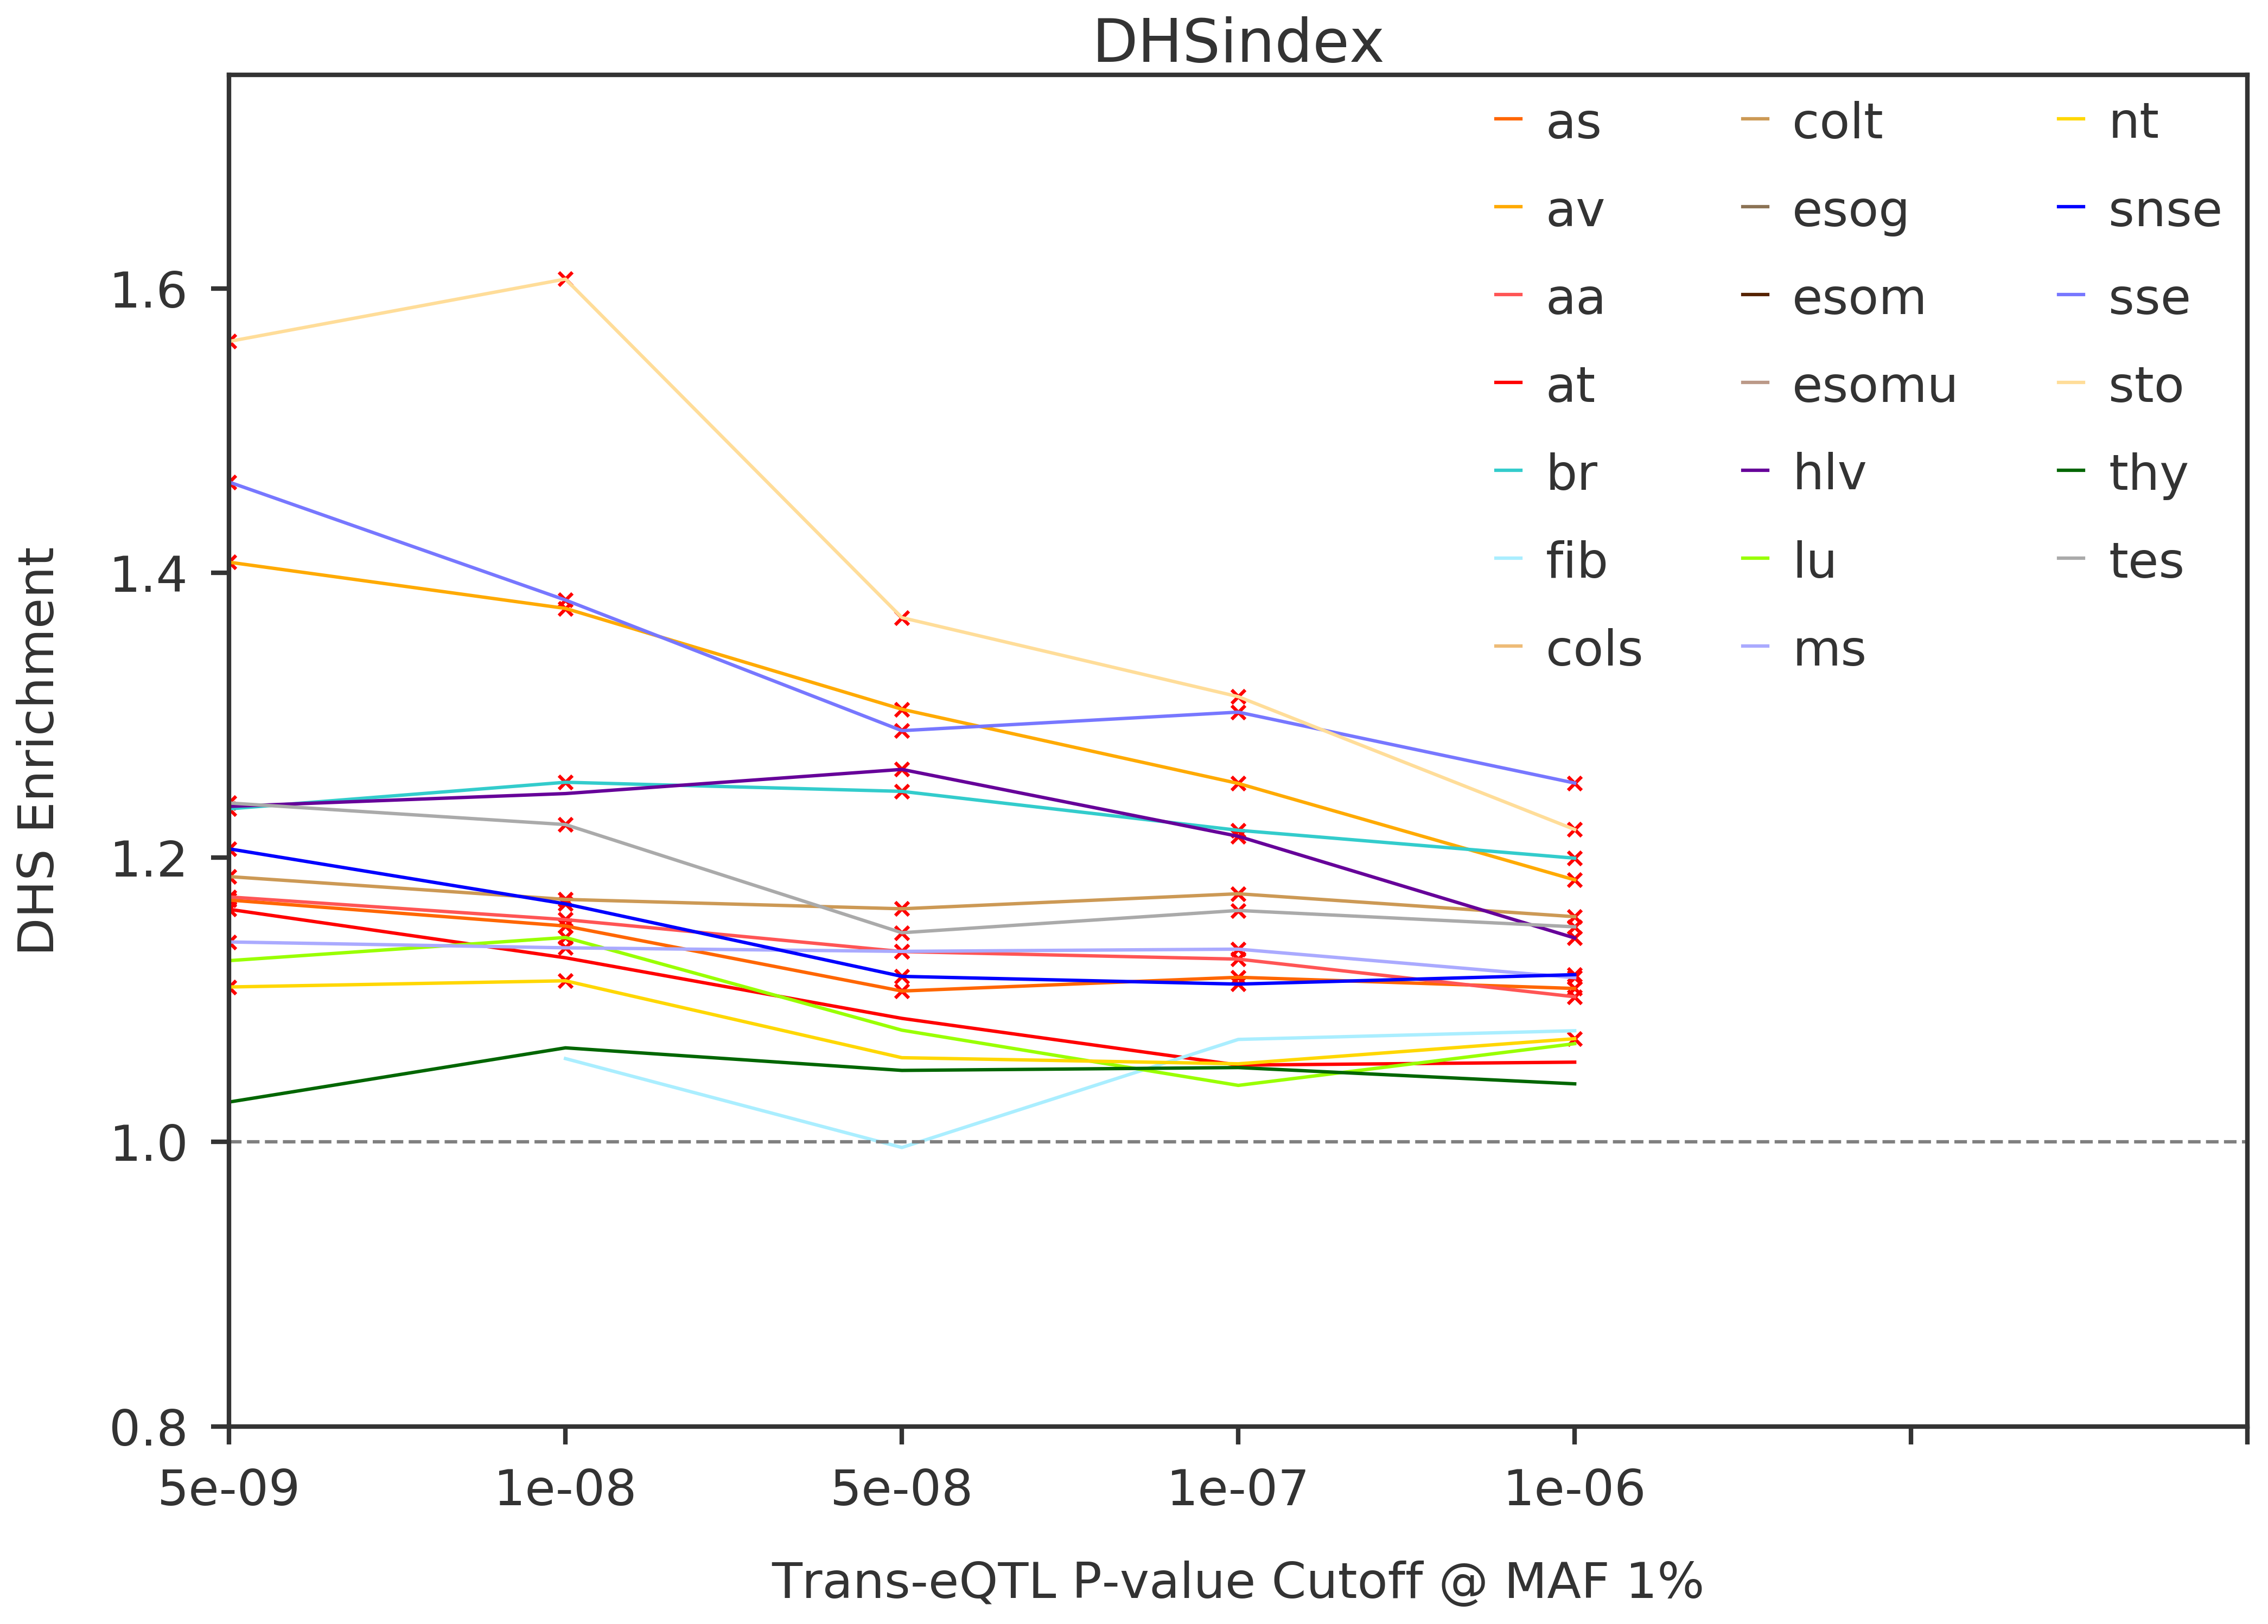

In [144]:
pcutoffs = [5e-9, 1e-8, 5e-8, 1e-7, 1e-6]
basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline"
# title = "multi_tissue"
title = "DHSindex"
outfile = os.path.join(basedir, "gtex_v8_pc_freeze/summary/dhs_enrichment_{:s}_pval_cutoffs_N250Samples.png".format(title))
maf = 0.01

fig = plt.figure(figsize = (16,11))
ax1 = fig.add_subplot(111)

transeqtls    = collections.defaultdict(dict)
dhs_annotated = collections.defaultdict(dict)
enrichment    = collections.defaultdict(dict)
e_pval        = collections.defaultdict(dict)
for i, pcutoff in enumerate(pcutoffs):
    infile = os.path.join(basedir, "gtex_v8_pc_freeze/summary/maf{:.2f}/dhs_enrichment_{:s}_{:g}.txt".format(maf, title, pcutoff))
    if os.path.exists(infile):
        with open(infile) as instream:
            next(instream)
            for line in instream:
                arr = line.strip().split("\t")
                t   = arr[0]
                transeqtls[pcutoff][t]    = int(arr[2])
                dhs_annotated[pcutoff][t] = int(arr[3])
                enrichment[pcutoff][t]    = float(arr[5])
                e_pval[pcutoff][t]        = float(arr[6])
                
for tshort in tshorts: #sorted_tissues: #
    performance = list()
    signif_dots = list()
    xpos        = list()
    xpos_dots   = list()
    for i, pcutoff in enumerate(pcutoffs):
        if tshort in transeqtls[pcutoff]:
            nteqtl = transeqtls[pcutoff][tshort]
            if nteqtl > 100 and tissue_samples[tshort] > 250:
                performance.append(enrichment[pcutoff][tshort])
                xpos.append(i)
                if e_pval[pcutoff][tshort] <= 0.01:
                    signif_dots.append(enrichment[pcutoff][tshort])
                    xpos_dots.append(i)
    if len(xpos) == 0:
        continue
    ax1.plot(xpos, performance, label = tshort, color=tissue_colors[tshort])
    ax1.scatter(xpos_dots,signif_dots, color='red', marker='x')
ax1.axhline(1, linestyle='--', color='gray')
ax1.set_xticklabels([str(x) for x in pcutoffs])
ax1.legend(ncol=3)
ax1.set_title(title)
ax1.set_xlim(0,6)
ax1.set_ylim(0.8, 1.75)
ax1.set_ylabel("DHS Enrichment")
ax1.set_xlabel("Trans-eQTL P-value Cutoff @ MAF {:g}%".format(maf*100))
plt.savefig(outfile, bbox_inches='tight')
plt.show()

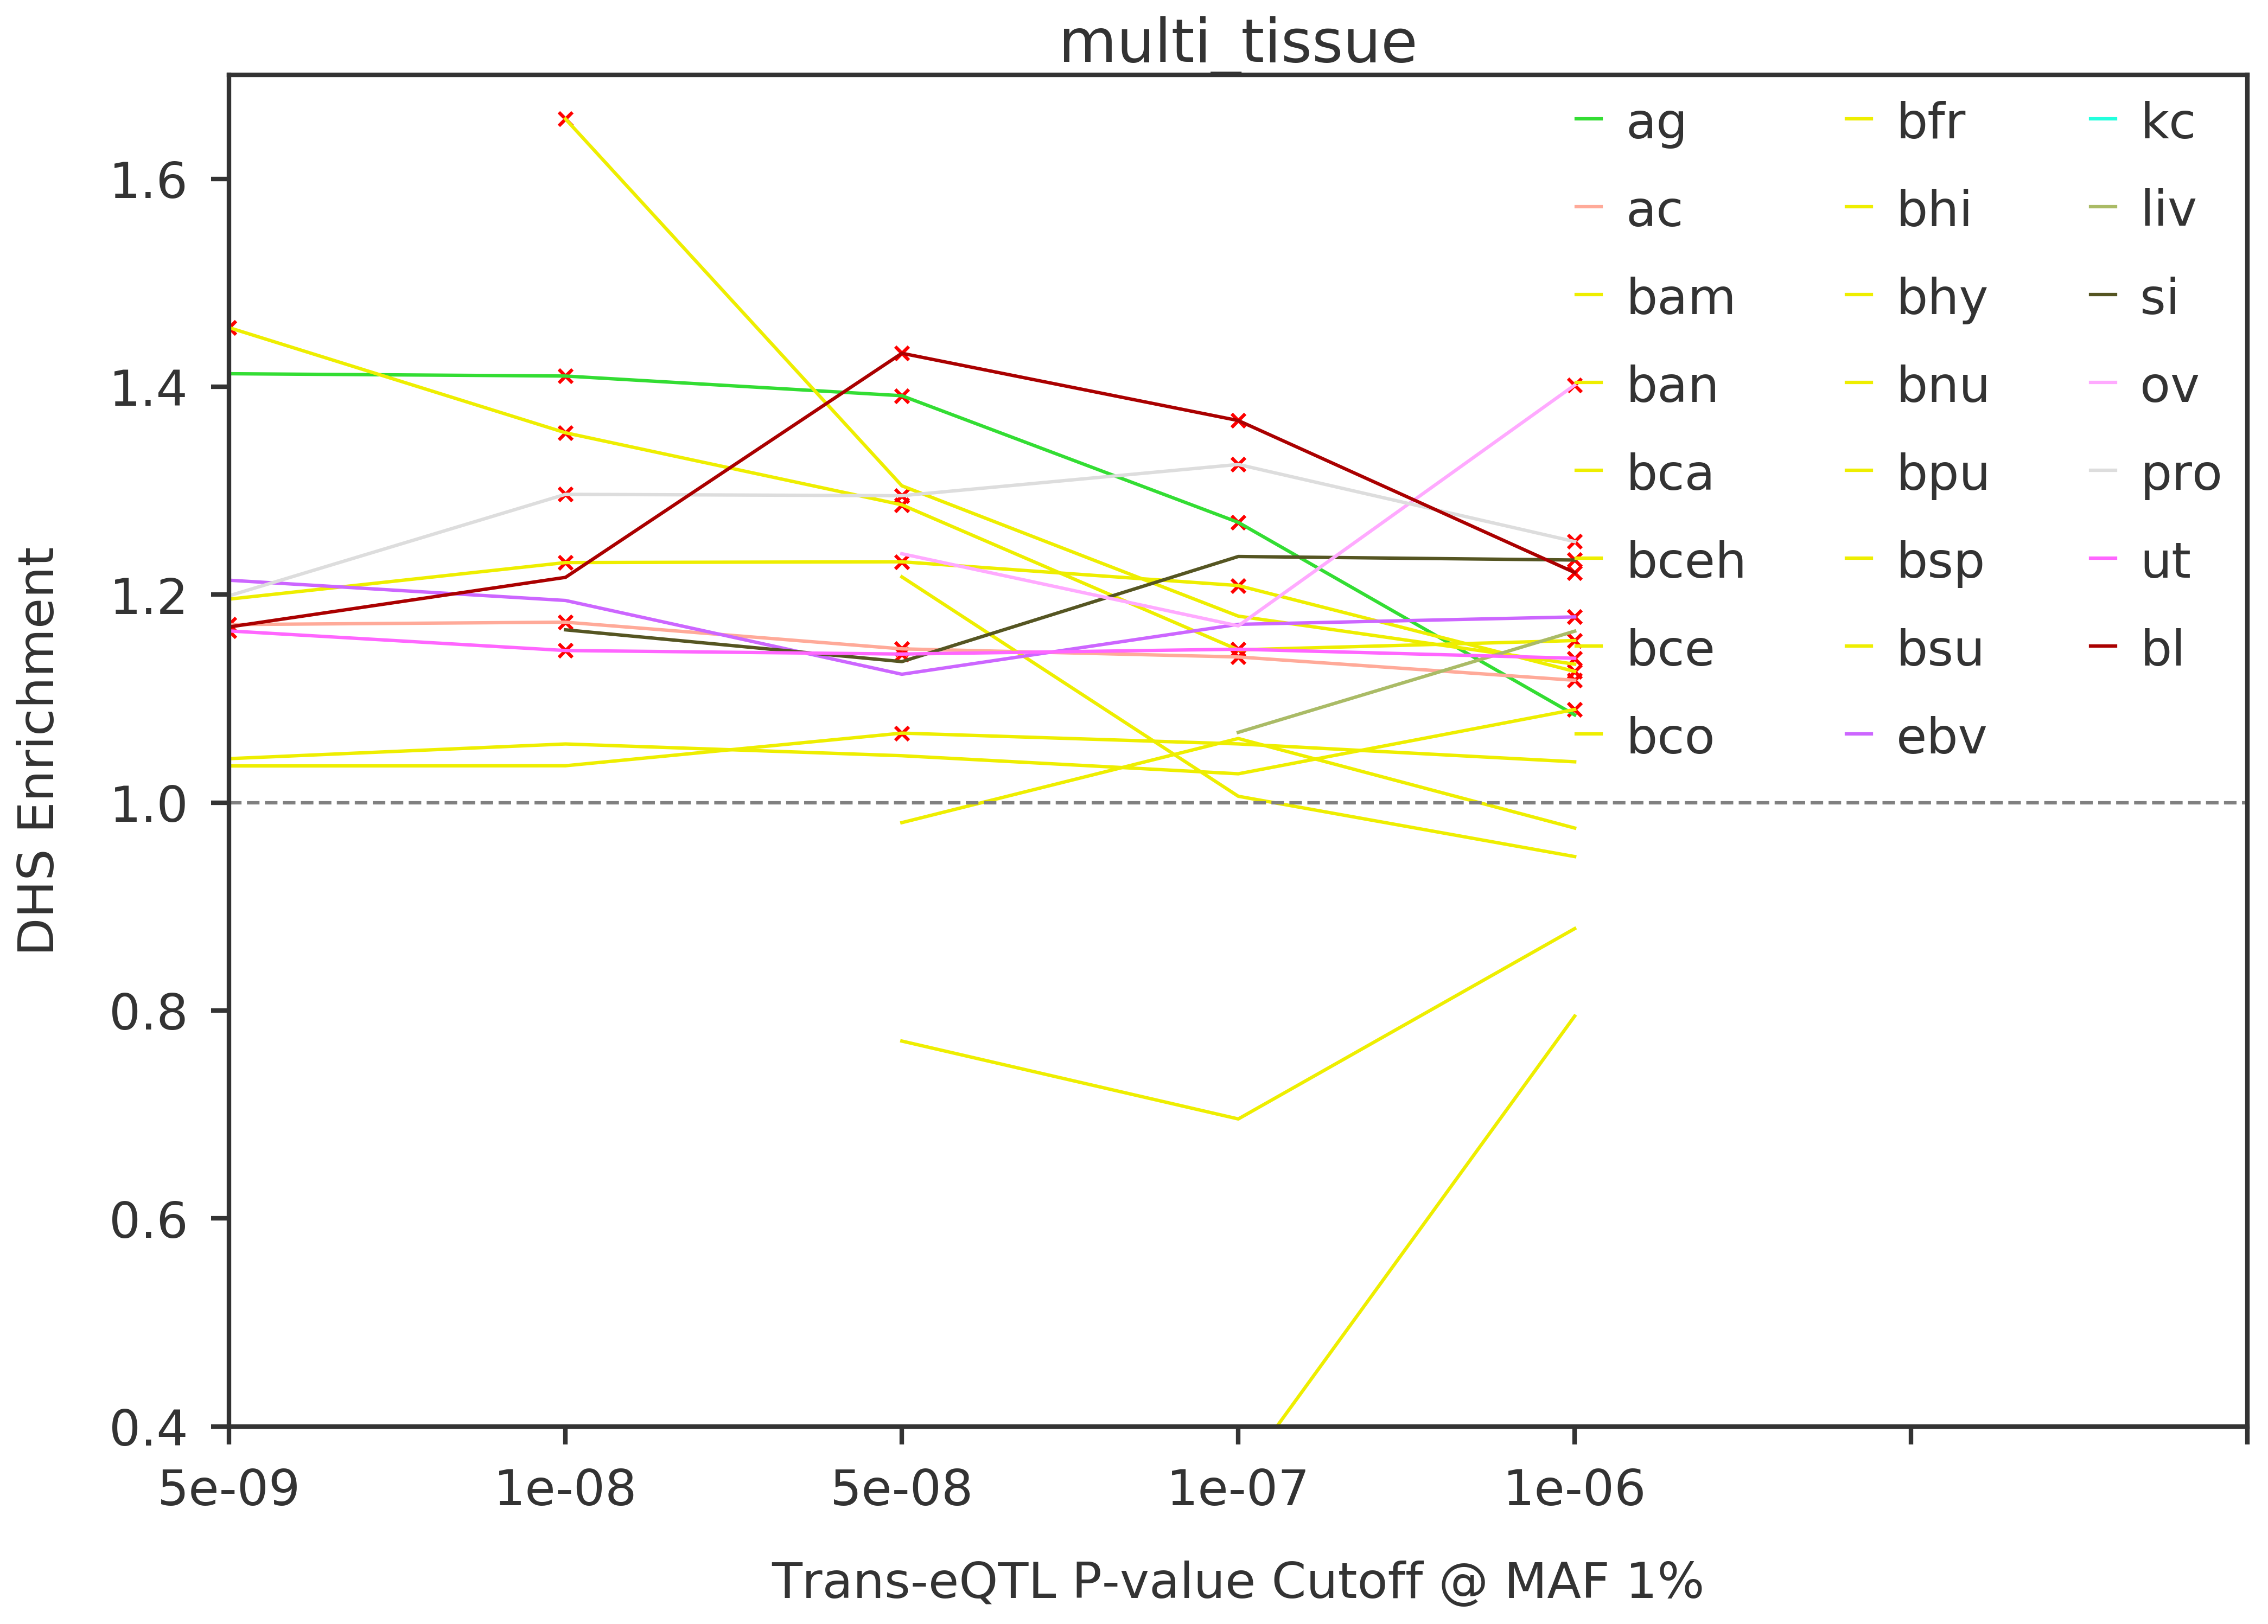

In [151]:
pcutoffs = [5e-9, 1e-8, 5e-8, 1e-7, 1e-6]
basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline"
title = "multi_tissue"
# title = "DHSindex"
outfile = os.path.join(basedir, "gtex_v8_pc_freeze/summary/dhs_enrichment_{:s}_pval_cutoffs_NLowSamples.png".format(title))

fig = plt.figure(figsize = (16,11))
ax1 = fig.add_subplot(111)

transeqtls    = collections.defaultdict(dict)
dhs_annotated = collections.defaultdict(dict)
enrichment    = collections.defaultdict(dict)
e_pval        = collections.defaultdict(dict)
for i, pcutoff in enumerate(pcutoffs):
    infile = os.path.join(basedir, "gtex_v8_pc_freeze/summary/maf0.01/dhs_enrichment_{:s}_{:g}.txt".format(title, pcutoff))
    if os.path.exists(infile):
        with open(infile) as instream:
            next(instream)
            for line in instream:
                arr = line.strip().split("\t")
                t   = arr[0]
                transeqtls[pcutoff][t]    = int(arr[2])
                dhs_annotated[pcutoff][t] = int(arr[3])
                enrichment[pcutoff][t]    = float(arr[5])
                e_pval[pcutoff][t]        = float(arr[6])
                
for tshort in tshorts: #sorted_tissues: #
    performance = list()
    xpos        = list()
    xpos_dots   = list()
    signif_dots = list()
    for i, pcutoff in enumerate(pcutoffs):
        if tshort in transeqtls[pcutoff]:
            nteqtl = transeqtls[pcutoff][tshort]
            if nteqtl > 100 and tissue_samples[tshort] <= 250:
                performance.append(enrichment[pcutoff][tshort])
                xpos.append(i)
                if e_pval[pcutoff][tshort] <= 0.01:
                    signif_dots.append(enrichment[pcutoff][tshort])
                    xpos_dots.append(i)
    if len(xpos) == 0:
        continue
    ax1.plot(xpos, performance, label = tshort, color=tissue_colors[tshort])
    ax1.scatter(xpos_dots,signif_dots, color='red', marker='x')
ax1.axhline(1, linestyle='--', color='gray')
ax1.set_xticklabels([str(x) for x in pcutoffs])
ax1.legend(ncol=3)
ax1.set_title(title)
ax1.set_xlim(0,6)
ax1.set_ylim(0.4, 1.7)
ax1.set_ylabel("DHS Enrichment")
ax1.set_xlabel("Trans-eQTL P-value Cutoff @ MAF {:g}%".format(maf*100))
plt.savefig(outfile, bbox_inches='tight')
plt.show()

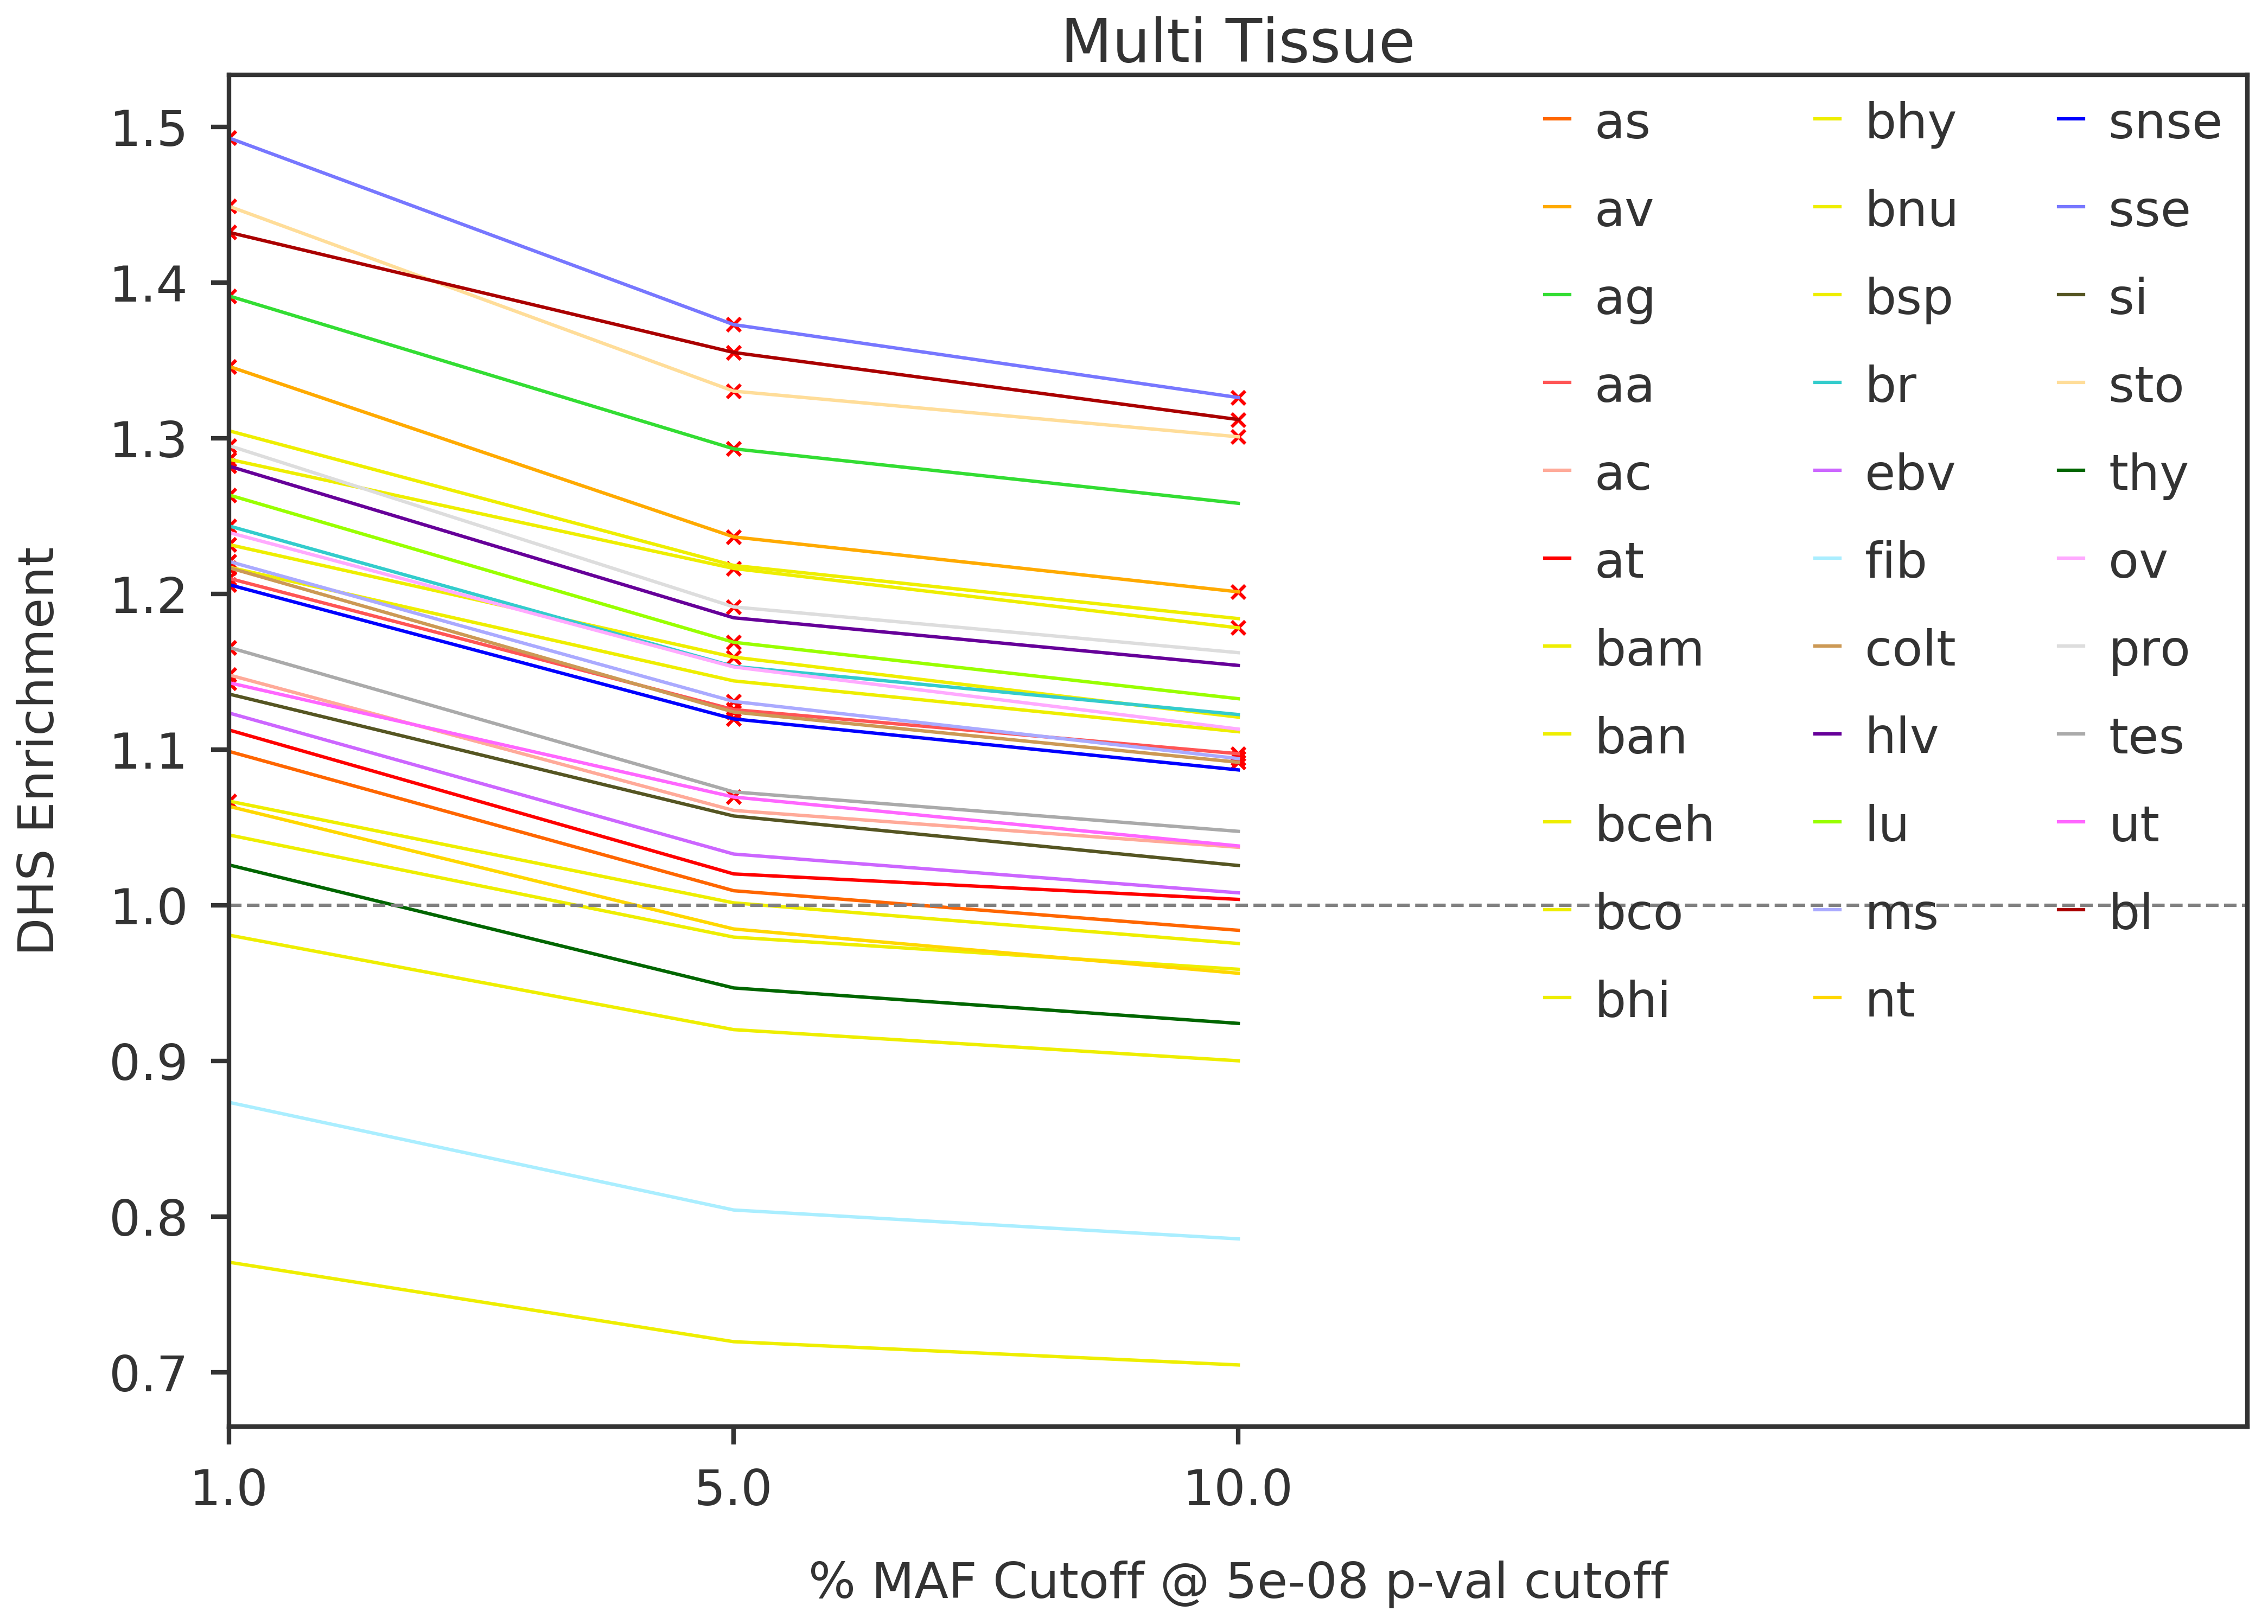

In [146]:
pcutoffs = [1e-8, 5e-8, 1e-7, 1e-6]
basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline"

mafs = [0.01, 0.05, 0.1]
pcutoff = pcutoffs[1]

fig = plt.figure(figsize = (16,11))
ax1 = fig.add_subplot(111)

transeqtls    = collections.defaultdict(dict)
dhs_annotated = collections.defaultdict(dict)
enrichment    = collections.defaultdict(dict)
e_pval        = collections.defaultdict(dict)
for i, maf in enumerate(mafs):
    infile = os.path.join(basedir, "gtex_v8_pc_freeze/summary/maf{:.2f}/dhs_enrichment_multi_tissue_{:g}.txt".format(maf, pcutoff))
    if os.path.exists(infile):
        with open(infile) as instream:
            next(instream)
            for line in instream:
                arr = line.strip().split("\t")
                t   = arr[0]
                transeqtls[maf][t]    = int(arr[2])
                dhs_annotated[maf][t] = int(arr[3])
                enrichment[maf][t]    = float(arr[5])
                e_pval[maf][t]        = float(arr[6])
                
for tshort in tshorts: #sorted_tissues: #
    performance = list()
    signif_dots = list()
    xpos        = list()
    xpos_dots   = list()
    for i, maf in enumerate(mafs):
        if tshort in transeqtls[maf]:
            nteqtl = transeqtls[maf][tshort]
            if nteqtl > 100: # and tissue_samples[tshort] > 250:
                performance.append(enrichment[maf][tshort])
                xpos.append(i)
                if e_pval[maf][tshort] <= 0.01:
                    signif_dots.append(enrichment[maf][tshort])
                    xpos_dots.append(i)
    if len(xpos) == 0:
        continue
    ax1.plot(xpos, performance, label = tshort, color=tissue_colors[tshort])
    ax1.scatter(xpos_dots,signif_dots, color='red', marker='x')
ax1.axhline(1, linestyle='--', color='gray')
ax1.set_xlim(0,4)
ax1.set_title("Multi Tissue")
ax1.set_xticks([0,1,2])
ax1.set_xticklabels([str(x*100) for x in mafs])
ax1.legend(ncol=3)
ax1.set_ylabel("DHS Enrichment")
ax1.set_xlabel("% MAF Cutoff @ {:g} p-val cutoff".format(pcutoff))
plt.show()

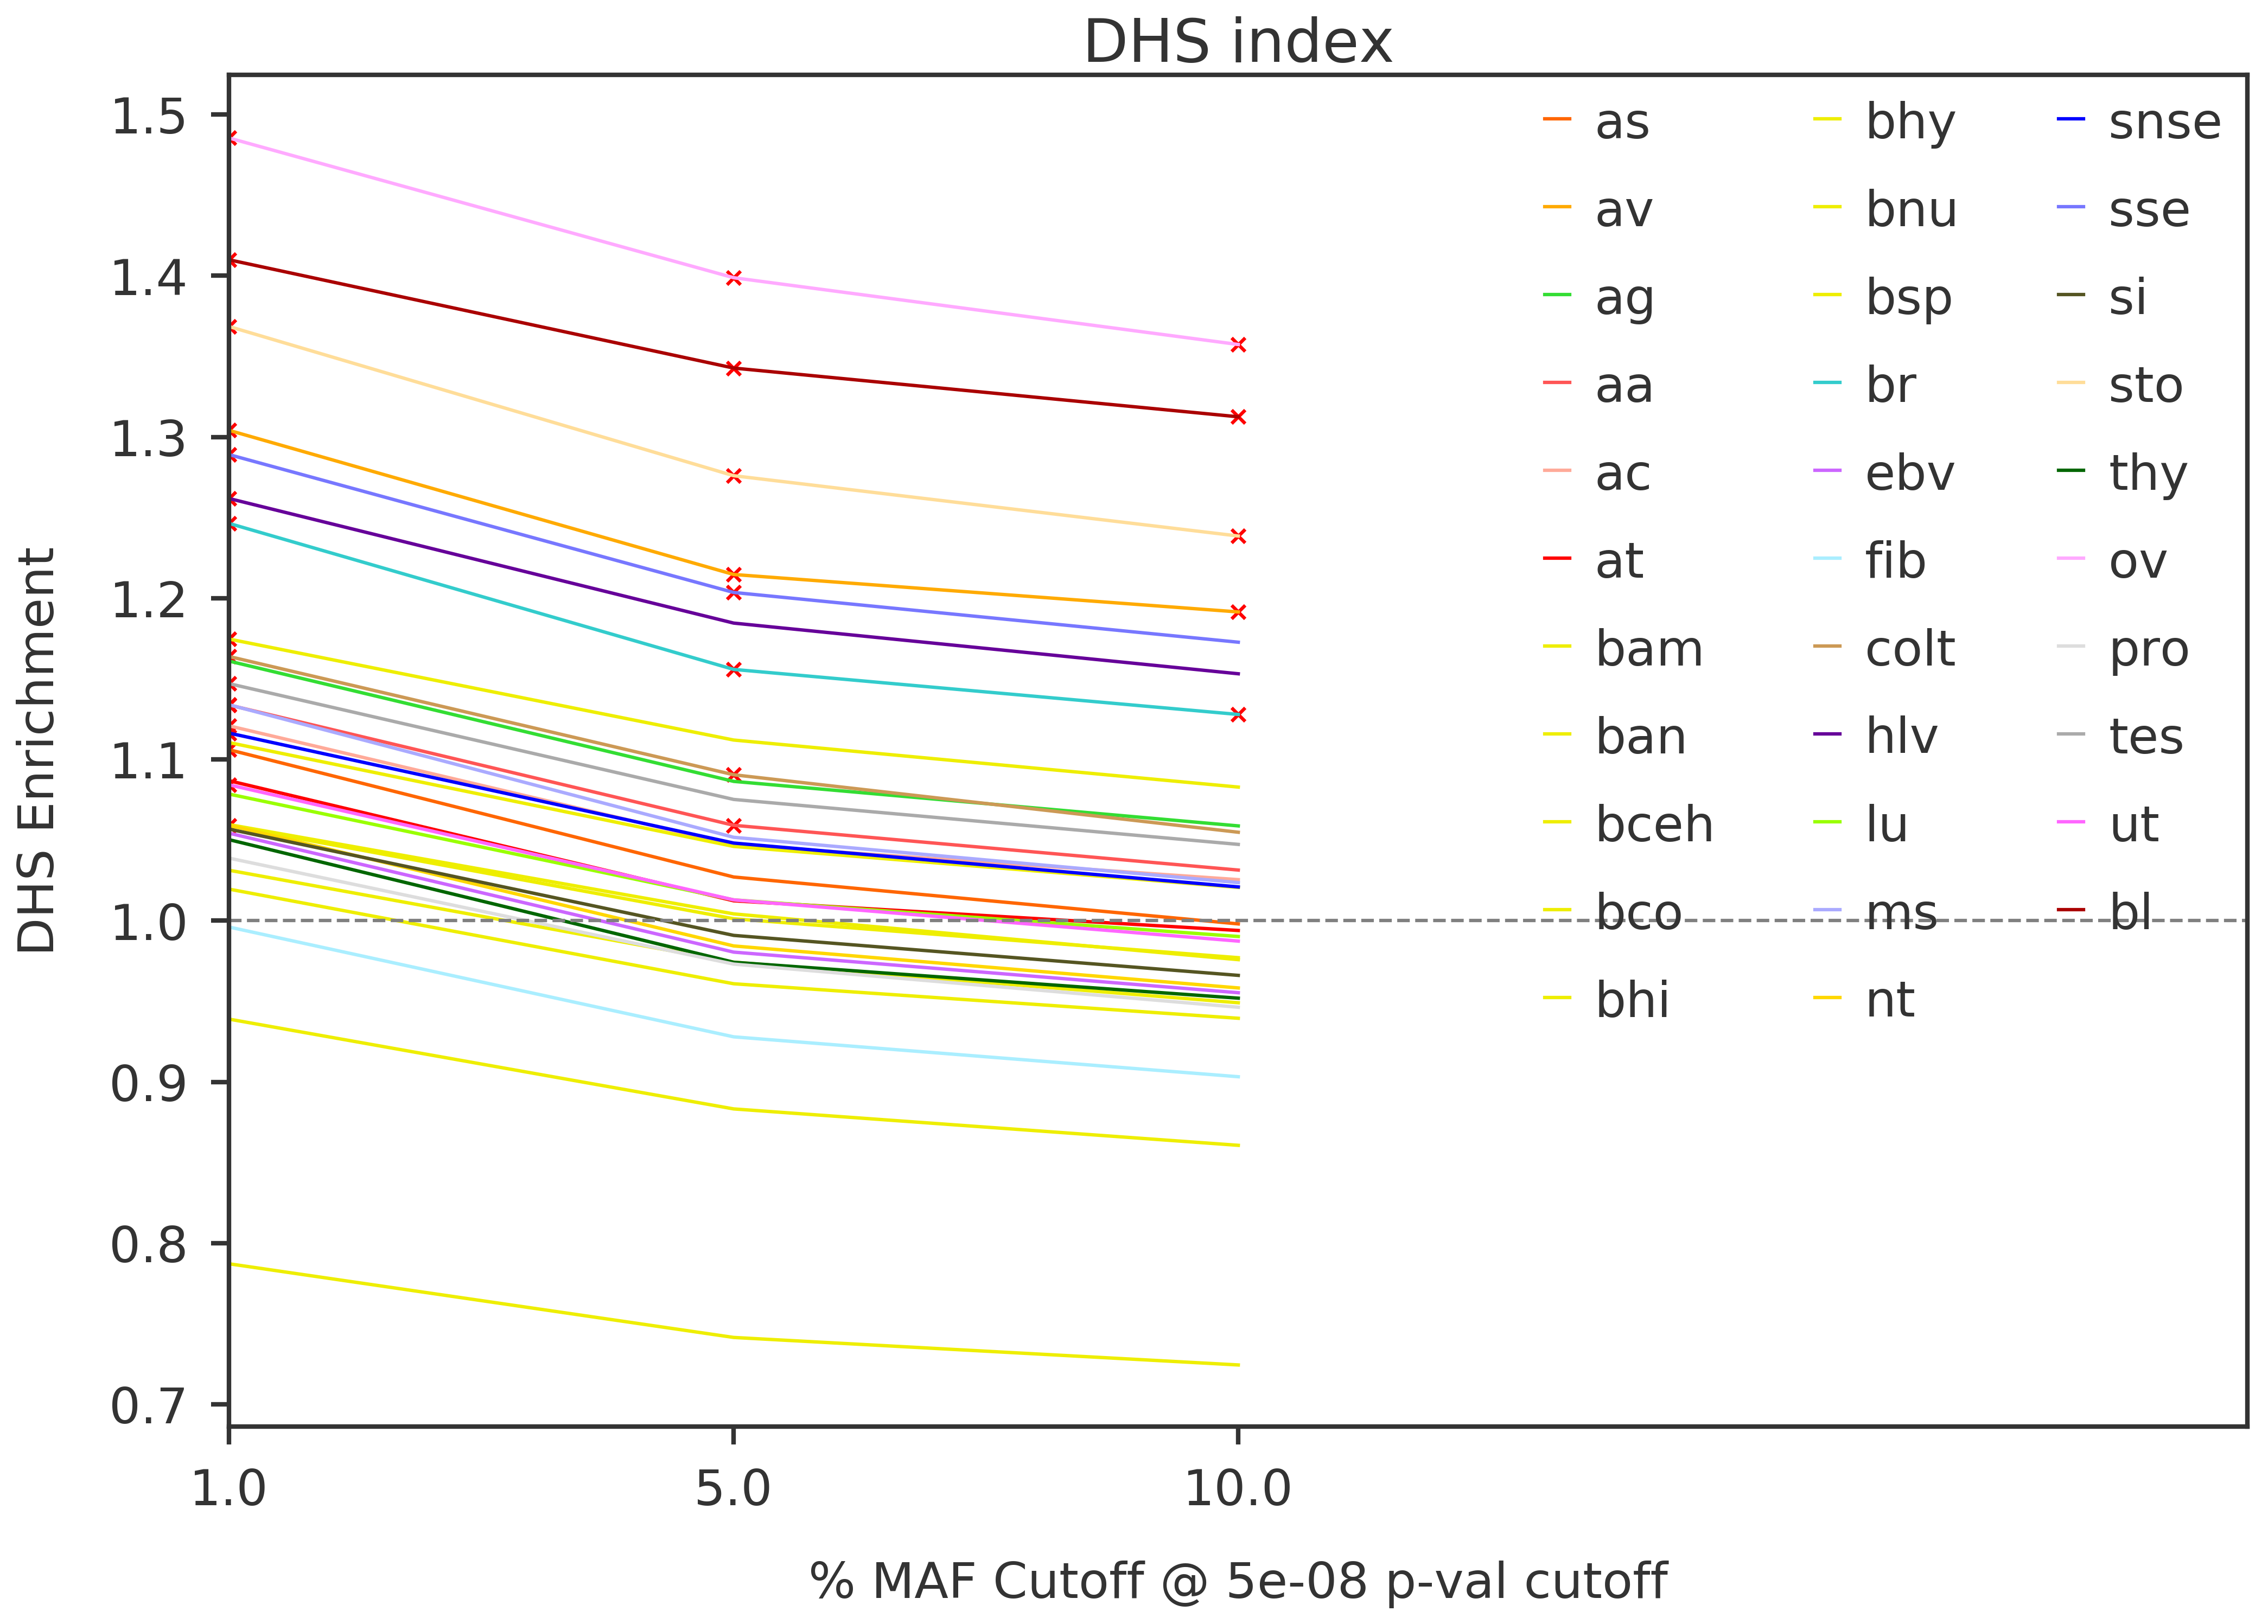

In [147]:
pcutoffs = [1e-8, 5e-8, 1e-7, 1e-6]
basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline"

mafs = [0.01, 0.05, 0.1]
pcutoff = pcutoffs[1]

fig = plt.figure(figsize = (16,11))
ax1 = fig.add_subplot(111)

transeqtls    = collections.defaultdict(dict)
dhs_annotated = collections.defaultdict(dict)
enrichment    = collections.defaultdict(dict)
e_pval        = collections.defaultdict(dict)
for i, maf in enumerate(mafs):
    infile = os.path.join(basedir, "gtex_v8_pc_freeze/summary/maf{:.2f}/dhs_enrichment_DHSindex_{:g}.txt".format(maf, pcutoff))
    if os.path.exists(infile):
        with open(infile) as instream:
            next(instream)
            for line in instream:
                arr = line.strip().split("\t")
                t   = arr[0]
                transeqtls[maf][t]    = int(arr[2])
                dhs_annotated[maf][t] = int(arr[3])
                enrichment[maf][t]    = float(arr[5])
                e_pval[maf][t]        = float(arr[6])
                
for tshort in tshorts: #sorted_tissues: #
    performance = list()
    signif_dots = list()
    xpos        = list()
    xpos_dots   = list()
    for i, maf in enumerate(mafs):
        if tshort in transeqtls[maf]:
            nteqtl = transeqtls[maf][tshort]
            if nteqtl > 100: # and tissue_samples[tshort] > 250:
                performance.append(enrichment[maf][tshort])
                xpos.append(i)
                if e_pval[maf][tshort] <= 0.01:
                    signif_dots.append(enrichment[maf][tshort])
                    xpos_dots.append(i)
    if len(xpos) == 0:
        continue
    ax1.plot(xpos, performance, label = tshort, color=tissue_colors[tshort])
    ax1.scatter(xpos_dots,signif_dots, color='red', marker='x')
ax1.axhline(1, linestyle='--', color='gray')
ax1.set_xlim(0,4)
ax1.set_title("DHS index")
ax1.set_xticks([0,1,2])
ax1.set_xticklabels([str(x*100) for x in mafs])
ax1.legend(ncol=3)
ax1.set_ylabel("DHS Enrichment")
ax1.set_xlabel("% MAF Cutoff @ {:g} p-val cutoff".format(pcutoff))
plt.show()